In [76]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


In [77]:
df_inf_path = pd.read_csv(
    "Testing coverage by infection type and bacterial pathogen_BLOOD-All.csv",
    sep=";",
    skiprows=4
)

df_path_abx = pd.read_csv(
    "Testing coverage by bacterial pathogen and antibiotic group_BLOOD-All.csv",
    sep=";",
    skiprows=4
)


In [78]:
print(df_inf_path.columns)
print(df_path_abx.columns)


Index(['Year,"Specimen","PathogenName","CTAs with Reported BCIs","CTAs with Reported BCIs with AST >= 80 BCIs","Total BCIs","Total BCIs with AST","Min","Q1","Median","Q3","Max"'], dtype='object')
Index(['Year,"Specimen","PathogenName","AntibioticName","CTAs with Reported BCIs","CTAs with Reported BCIs with AST >= 80 BCIs","Total BCIs","Total BCIs with AST","Min","Q1","Median","Q3","Max"'], dtype='object')


In [79]:
df_inf_path.columns = df_inf_path.columns.str.replace('"', '', regex=False).str.strip()
df_path_abx.columns = df_path_abx.columns.str.replace('"', '', regex=False).str.strip()


In [80]:
print(df_inf_path.columns)
print(df_path_abx.columns)


Index(['Year,Specimen,PathogenName,CTAs with Reported BCIs,CTAs with Reported BCIs with AST >= 80 BCIs,Total BCIs,Total BCIs with AST,Min,Q1,Median,Q3,Max'], dtype='object')
Index(['Year,Specimen,PathogenName,AntibioticName,CTAs with Reported BCIs,CTAs with Reported BCIs with AST >= 80 BCIs,Total BCIs,Total BCIs with AST,Min,Q1,Median,Q3,Max'], dtype='object')


In [81]:
df_inf_path.head(3), df_path_abx.head(3)


(  Year,Specimen,PathogenName,CTAs with Reported BCIs,CTAs with Reported BCIs with AST >= 80 BCIs,Total BCIs,Total BCIs with AST,Min,Q1,Median,Q3,Max
 0  2016,"BLOOD","Acinetobacter spp.",19,19,3930,3...                                                                                                
 1  2017,"BLOOD","Acinetobacter spp.",48,46,13633,...                                                                                                
 2  2018,"BLOOD","Acinetobacter spp.",60,50,20741,...                                                                                                ,
   Year,Specimen,PathogenName,AntibioticName,CTAs with Reported BCIs,CTAs with Reported BCIs with AST >= 80 BCIs,Total BCIs,Total BCIs with AST,Min,Q1,Median,Q3,Max
 0  2016,"BLOOD","Acinetobacter spp.","",NA,NA,NA,...                                                                                                               
 1  2017,"BLOOD","Acinetobacter spp.","",NA,NA,NA,...                

In [82]:
import pandas as pd
df_inf_path = pd.read_csv(
    "Testing coverage by infection type and bacterial pathogen_BLOOD-All.csv",
    skiprows=4
)

df_path_abx = pd.read_csv(
    "Testing coverage by bacterial pathogen and antibiotic group_BLOOD-All.csv",
    skiprows=4
)


In [83]:
print(df_inf_path.columns)
print(df_path_abx.columns)


Index(['Year', 'Specimen', 'PathogenName', 'CTAs with Reported BCIs',
       'CTAs with Reported BCIs with AST >= 80 BCIs', 'Total BCIs',
       'Total BCIs with AST', 'Min', 'Q1', 'Median', 'Q3', 'Max'],
      dtype='object')
Index(['Year', 'Specimen', 'PathogenName', 'AntibioticName',
       'CTAs with Reported BCIs',
       'CTAs with Reported BCIs with AST >= 80 BCIs', 'Total BCIs',
       'Total BCIs with AST', 'Min', 'Q1', 'Median', 'Q3', 'Max'],
      dtype='object')


In [84]:
df_inf_path["PathogenName"] = df_inf_path["PathogenName"].astype(str).str.strip()
df_path_abx["PathogenName"] = df_path_abx["PathogenName"].astype(str).str.strip()


In [85]:
df_inf_path["PathogenName"] = df_inf_path["PathogenName"].astype(str).str.strip()
df_path_abx["PathogenName"] = df_path_abx["PathogenName"].astype(str).str.strip()


In [88]:
#(infection type × pathogen)
inf_agg = (
    df_inf_path
    .groupby("PathogenName")
    .agg(
        infection_record_count=("Year", "count"),
        total_bcis_infection=("Total BCIs", "sum")
    )
    .reset_index()
)


In [89]:
# (pathogen × antibiotic group)
abx_agg = (
    df_path_abx
    .groupby("PathogenName")
    .agg(
        antibiotic_group_count=("AntibioticName", "nunique"),
        total_bcis_antibiotic=("Total BCIs", "sum")
    )
    .reset_index()
)


In [90]:
features_df = pd.merge(
    inf_agg,
    abx_agg,
    on="PathogenName",
    how="inner"
)


In [91]:
features_df.head()


,PathogenName,infection_record_count,total_bcis_infection,antibiotic_group_count,total_bcis_antibiotic
0,Acinetobacter spp.,8,233333,1,233333.0
1,Escherichia coli,8,2137559,2,4275118.0
2,Klebsiella pneumoniae,8,812339,2,1624678.0
3,Salmonella spp.,8,70727,1,70727.0
4,Staphylococcus aureus,8,1047305,1,1047305.0


In [92]:
# SELECTIVE PRESSURE
features_df["infection_diversity"] = (
    features_df["infection_record_count"] /
    features_df["infection_record_count"].max()
)

features_df["antibiotic_diversity"] = (
    features_df["antibiotic_group_count"] /
    features_df["antibiotic_group_count"].max()
)

features_df["total_testing_coverage"] = (
    features_df["total_bcis_infection"] +
    features_df["total_bcis_antibiotic"]
)


In [93]:
#clustering model 1
X = features_df[
    [
        "infection_record_count",
        "antibiotic_group_count",
        "infection_diversity",
        "antibiotic_diversity",
        "total_testing_coverage"
    ]
]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
features_df["cluster_id"] = kmeans.fit_predict(X_scaled)


In [95]:
# INTERPRET & LABEL CLUSTERS
centroids = pd.DataFrame(
    kmeans.cluster_centers_,
    columns=X.columns
)

order = centroids["antibiotic_diversity"].sort_values().index.tolist()

cluster_map = {
    order[0]: "narrow_exposure",
    order[1]: "moderate_exposure",
    order[2]: "broad_exposure"
}

features_df["exposure_cluster"] = features_df["cluster_id"].map(cluster_map)


In [96]:
# export
final_df = features_df[
    [
        "PathogenName",
        "exposure_cluster",
        "infection_record_count",
        "antibiotic_group_count",
        "infection_diversity",
        "antibiotic_diversity",
        "total_testing_coverage"
    ]
]

final_df.to_csv("selective_pressure_clusters.csv", index=False)
final_df.to_json("selective_pressure_clusters.json", orient="records", indent=2)


In [97]:
# Model 2
df_path_abx_core = df_path_abx[
    [
        "Year",
        "PathogenName",
        "AntibioticName",
        "Total BCIs"
    ]
].copy()


In [99]:
# AGGREGATE EXPOSURE FREQUENCY
pathway_agg = (
    df_path_abx_core
    .groupby(["PathogenName", "AntibioticName"])
    .agg(
        exposure_records=("Year", "count"),
        total_bcis=("Total BCIs", "sum")
    )
    .reset_index()
)


In [100]:
pathway_agg["exposure_score"] = (
    pathway_agg["total_bcis"] /
    pathway_agg["total_bcis"].max()
)


In [101]:
pathway_agg = pathway_agg.sort_values(
    by="exposure_score",
    ascending=False
)


In [102]:
# export
pathway_agg.to_csv(
    "exposure_pathways.csv",
    index=False
)


In [103]:
pathway_agg.to_json(
    "exposure_pathways.json",
    orient="records",
    indent=2
)


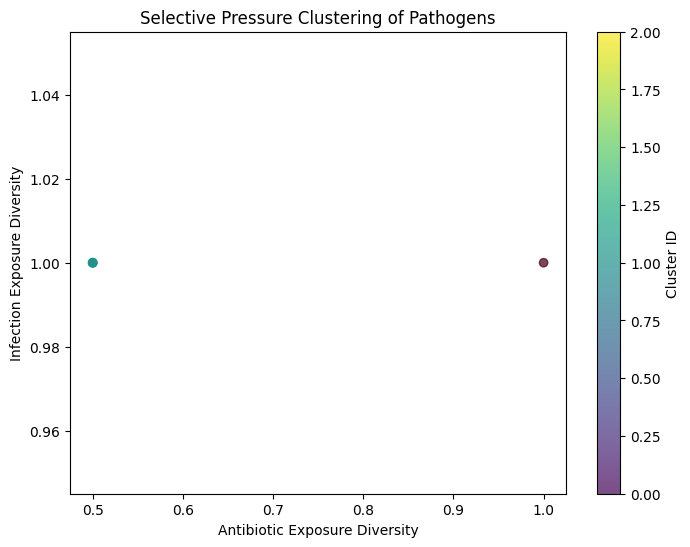

In [104]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(
    features_df["antibiotic_diversity"],
    features_df["infection_diversity"],
    c=features_df["cluster_id"],
    cmap="viridis",
    alpha=0.7
)

plt.xlabel("Antibiotic Exposure Diversity")
plt.ylabel("Infection Exposure Diversity")
plt.title("Selective Pressure Clustering of Pathogens")
plt.colorbar(label="Cluster ID")
plt.show()


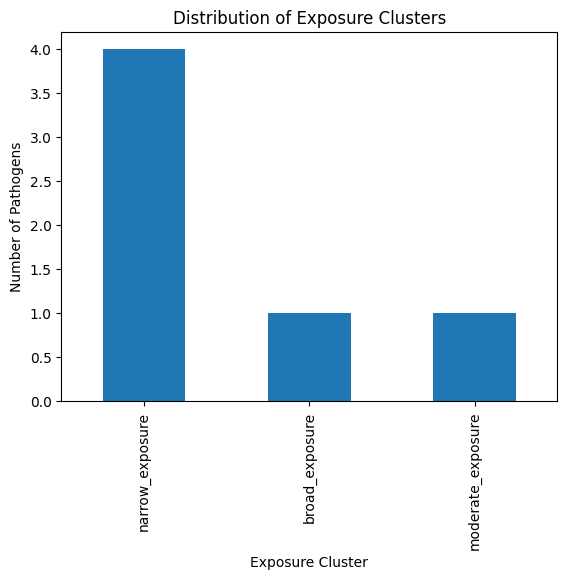

In [105]:
features_df["exposure_cluster"].value_counts().plot(
    kind="bar",
    title="Distribution of Exposure Clusters",
    xlabel="Exposure Cluster",
    ylabel="Number of Pathogens"
)
plt.show()


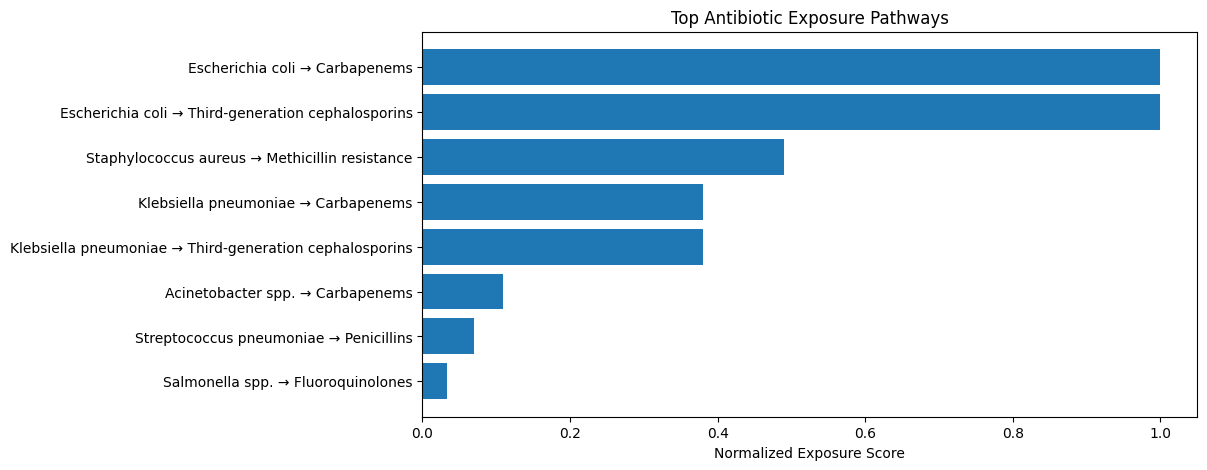

In [106]:
top10 = pathway_agg.head(10)

plt.figure(figsize=(10,5))
plt.barh(
    top10["PathogenName"] + " → " + top10["AntibioticName"],
    top10["exposure_score"]
)
plt.xlabel("Normalized Exposure Score")
plt.title("Top Antibiotic Exposure Pathways")
plt.gca().invert_yaxis()
plt.show()
